In [1]:
from datasets import load_dataset
import os

import uuid
from tqdm import tqdm
import json

/home/omote/cluster_project/iam2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def make_id():
    return str(uuid.uuid4())

def make_conversation(id,image_path,question,answer,image_folder_root=None):
    if image_folder_root is not None:
        image_path = os.path.join(image_folder_root, image_path)
    return_data =   {
        "id": id,
        "image": image_path,
        "conversations": [
        {
            "from": "human",
            "value": f"<image>\n{question}"
        },
        {
            "from": "gpt",
            "value": answer
        },
        ]
    }
    return return_data


def make_question(caption):
    return  f"Provide the bounding box coordinate of the region this sentence describes: {caption}"

def bbox_absolute_to_relative(absolute_bbox, image_width_height):
    width, height = image_width_height
    x1 = absolute_bbox[0] / width
    y1 = absolute_bbox[1] / height
    x2 = absolute_bbox[2] / width
    y2 = absolute_bbox[3] / height
    relative_bbox = [x1, y1, x2, y2]
    return relative_bbox

def make_answer(bbox, image_width_height):
    relative_bbox = bbox_absolute_to_relative(bbox, image_width_height)
    relative_bbox = [f"{coord:.3f}" for coord in relative_bbox]
    
    return f"[{relative_bbox[0]},{relative_bbox[1]},{relative_bbox[2]},{relative_bbox[3]}]"

In [3]:
dataset_root_dir = "/home/omote/local-share-data_ssd/huggingface_dataset"
cache_dir = "/home/omote/local-share-data_ssd/huggingface_cache"
save_json_path = "/home/omote/local-share-data_ssd/refcoco_g/refcoco_g_llava-onevision.json"

dataset_id = os.path.join("jxu124/refcocog")

dataset = load_dataset(dataset_id, cache_dir=cache_dir, split="train")

In [4]:
print(dataset[0])
for key, value in dataset[0].items():
    print(f"{key}: {value}")

{'image_id': 519404, 'split': 'train', 'sentences': [{'raw': 'Two woman one in black eatting and the other has a white shirt at the desk', 'sent': 'two woman one in black eatting and the other has a white shirt at the desk', 'sent_id': 0, 'tokens': ['two', 'woman', 'one', 'in', 'black', 'eatting', 'and', 'the', 'other', 'has', 'a', 'white', 'shirt', 'at', 'the', 'desk']}, {'raw': 'Woman in white shirt looking down at laptop computer.', 'sent': 'woman in white shirt looking down at laptop computer', 'sent_id': 1, 'tokens': ['woman', 'in', 'white', 'shirt', 'looking', 'down', 'at', 'laptop', 'computer']}], 'file_name': 'COCO_train2014_000000519404_1241542.jpg', 'category_id': 1, 'ann_id': 1241542, 'sent_ids': [0, 1], 'ref_id': 5023, 'raw_anns': '{"segmentation": [[16.22, 84.86, 36.76, 52.43, 69.19, 45.95, 108.11, 50.27, 118.92, 60.0, 134.05, 76.22, 132.97, 104.32, 145.95, 128.11, 151.35, 143.24, 143.78, 164.86, 139.46, 174.59, 151.35, 191.89, 189.19, 223.24, 230.27, 265.41, 235.68, 268.6

In [5]:
converted_data = []

for sample in tqdm(dataset):
    id = make_id()

    raw_image_info = json.loads(sample["raw_image_info"])
    image_file_name = raw_image_info["file_name"]
    original_image_width_height = (raw_image_info["width"], raw_image_info["height"])
    image_path = os.path.join("mscoco2014/train2014",image_file_name)
    bbox = sample["bbox"]
    caption_list = [sentences["raw"] for sentences in sample["sentences"]]
    
    for caption in caption_list:
        question = make_question(caption)
        answer = make_answer(bbox, original_image_width_height)
        conversation = make_conversation(id,image_path,question,answer)
        converted_data.append(conversation)


100%|██████████| 42226/42226 [00:13<00:00, 3069.02it/s]


In [6]:
print("len(converted_data):",len(converted_data))
for i in range(5):
    for key, value in converted_data[i].items():
        print(f"{key}: {value}")

len(converted_data): 80512
id: 1bcfa105-b7fb-44aa-9fd4-6439fcb79beb
image: mscoco2014/train2014/COCO_train2014_000000519404.jpg
conversations: [{'from': 'human', 'value': '<image>\nProvide the bounding box coordinate of the region this sentence describes: Two woman one in black eatting and the other has a white shirt at the desk'}, {'from': 'gpt', 'value': '[0.000,0.096,0.373,0.947]'}]
id: 1bcfa105-b7fb-44aa-9fd4-6439fcb79beb
image: mscoco2014/train2014/COCO_train2014_000000519404.jpg
conversations: [{'from': 'human', 'value': '<image>\nProvide the bounding box coordinate of the region this sentence describes: Woman in white shirt looking down at laptop computer.'}, {'from': 'gpt', 'value': '[0.000,0.096,0.373,0.947]'}]
id: f0189018-6a24-4064-abff-dacdc5515a06
image: mscoco2014/train2014/COCO_train2014_000000181828.jpg
conversations: [{'from': 'human', 'value': '<image>\nProvide the bounding box coordinate of the region this sentence describes: A TV with a woman being interviewed on it

In [7]:
if not os.path.exists(os.path.dirname(save_json_path)):
    os.makedirs(os.path.dirname(save_json_path))
with open(save_json_path, "w") as f:
    json.dump(converted_data, f, indent=4, ensure_ascii=False)

In [8]:
with open(save_json_path, "r") as f:
    loaded_data = json.load(f)
print("len(loaded_data):",len(loaded_data))

len(loaded_data): 80512


In [9]:
image_folder_root = "/home/omote/local-share-data_ssd"

exist_image_count = 0
for i in tqdm(range(len(loaded_data))):
    image_file_name = loaded_data[i]["image"]
    image_path = os.path.join(image_folder_root,image_file_name)
    if not os.path.exists(image_path):
        print(f"Image file does not exist: {image_path}")
        continue
    exist_image_count += 1
print("exist_image_count:", exist_image_count)
print("non_exist_image_count:", len(loaded_data) - exist_image_count)
print("exist_image_count / len(loaded_data):", exist_image_count / len(loaded_data))

100%|██████████| 80512/80512 [00:03<00:00, 20226.77it/s]

exist_image_count: 80512
non_exist_image_count: 0
exist_image_count / len(loaded_data): 1.0


<image>
Provide the bounding box coordinate of the region this sentence describes: Parking meter with a closed dial on the right of another parking meter.


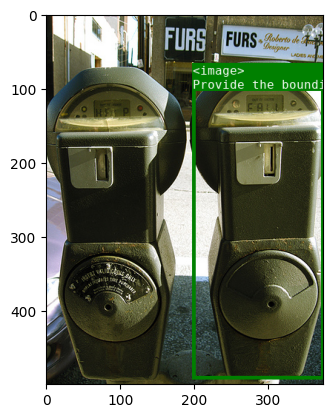

In [13]:
import imgviz
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from PIL import Image

def visualize_bbox(image, bbox, caption):
    bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    labels = [2]
    image = imgviz.instances2rgb(np.array(image), bboxes=bboxes, labels=labels,captions=[caption],font_size=16)

    plt.imshow(image)
    plt.show()
    
def extract_bbox_from_text(ans):
    pattern = re.compile(r'\[(((0|1)\.(\d){3}\,){3}((0|1)\.(\d){3}))\]')
    match_list = pattern.findall(ans)

    if len(match_list) > 0:
        answer = [list(map(float,match[0].split(","))) for match in match_list]
    else:
        answer = "FAILED"
    return answer

def bbox_relative_to_absolute(relative_bbox, image_width_height):
    width, height = image_width_height
    x1 = relative_bbox[0] * width
    y1 = relative_bbox[1] * height
    x2 = relative_bbox[2] * width
    y2 = relative_bbox[3] * height
    absolute_bbox = [x1, y1, x2, y2]
    return absolute_bbox



sample_data = loaded_data[-400]

image_path = sample_data["image"]
image_path = os.path.join(image_folder_root,image_path)
image = Image.open(image_path)
original_image_width_height = (image.width, image.height)

answer = sample_data["conversations"][1]["value"]
relative_bbox = extract_bbox_from_text(answer)[0]
absolute_bbox = bbox_relative_to_absolute(relative_bbox, original_image_width_height)

print(sample_data["conversations"][0]["value"])
visualize_bbox(image, absolute_bbox, sample_data["conversations"][0]["value"])
